In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df

In [2]:
neg_test = pd.read_csv('neg_testdate.csv',index_col=0)
pos_test = pd.read_csv('pos_testdate.csv',index_col=0)
lc_u = np.load('uid_per_shb_fatigue.npy')

In [3]:
def get_epoch(user_ids):
    
   
    ft = tuple(user_ids)    
    df = query_ch_df(
            #"""DESCRIBE TABLE rocs.test_table"""
        #"""SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {formatter}"""
        """SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {}""".format(ft) 
        #"""SELECT * FROM rocs.vital_data_epoch LIMIT 5000"""
        )
    return df

In [4]:
#posmatch = pd.read_csv('posmatch.csv')['user_id'].values

In [5]:
pos = get_epoch([300313])

In [6]:
# for p in posmatch:
#     try:
#         pos = get_epoch([p])
#         if len(pos) > 1000000:
#             print(p)
#     except:
#         continue
    

In [7]:
neg = get_epoch([183492])

In [8]:
lc = get_epoch([357322])

In [9]:
import datetime

In [10]:
value_types = pd.read_csv('epoch_value_types.csv')
value_types = value_types.rename(columns={"id": "type"})

In [11]:
pos = pos.rename(columns={"customer": "user_id"})
neg = neg.rename(columns={"customer": "user_id"})
lc = lc.rename(columns={"customer": "user_id"})


In [12]:
# get test date 
lc = lc.merge(pos_test[pos_test['user_id'].isin(lc['user_id'].values)], how='left', on='user_id')
lc['dt'] = pd.to_datetime(lc['dt'])

pos = pos.merge(pos_test[pos_test['user_id'].isin(pos['user_id'].values)], how='left', on='user_id')
pos['dt'] = pd.to_datetime(pos['dt'])

neg = neg.merge(neg_test[neg_test['user_id'].isin(neg['user_id'].values)], how='left', on='user_id')
neg['dt'] = pd.to_datetime(neg['dt'])

In [13]:
def modify_df(user_df):
    user_df.startTimestamp = user_df.startTimestamp//1000
    user_df.endTimestamp = user_df.endTimestamp//1000
    user_df.startTimestamp = user_df.startTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    user_df.endTimestamp = user_df.endTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    user_df['date'] = user_df.startTimestamp.apply(lambda x: x.date())
    
    user_df = user_df.merge(value_types, how='left', on = 'type')
    user_df['entries'] = 1
    
    user_df['tdelta'] = user_df['endTimestamp'] - user_df['startTimestamp']
    user_df['tdelta_min'] = user_df['tdelta'].apply(lambda x: x.total_seconds()//60)
    user_df['tdelta_sec'] = user_df['tdelta'].apply(lambda x: x.total_seconds())
    user_df['date'] = pd.to_datetime(user_df['date'])
    td = user_df['date'] - user_df['dt']  
    user_df['week_totest'] = td.apply(lambda x: -(x.days// - 7))
    
    return user_df

In [14]:
lc = modify_df(lc)
pos = modify_df(pos)
neg = modify_df(neg)

In [15]:
def phases(week):
    if week < 0:
        ph = 0
    elif (week >= 0 and week <= 3):
        ph = 1
    elif week > 3:
        ph = 2
    return ph

In [16]:
lc['phase'] = lc['week_totest'].apply(lambda x: phases(x))
pos['phase'] = pos['week_totest'].apply(lambda x: phases(x))
neg['phase'] = neg['week_totest'].apply(lambda x: phases(x))

In [32]:
plt.rcParams['font.size']=20

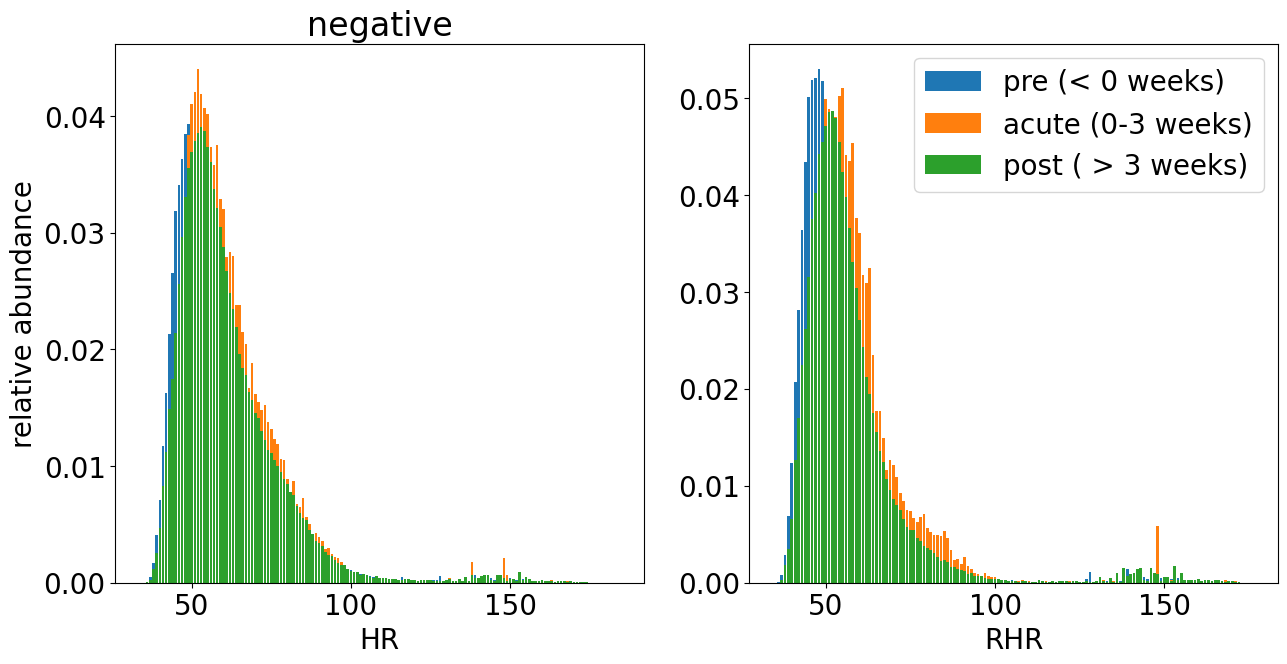

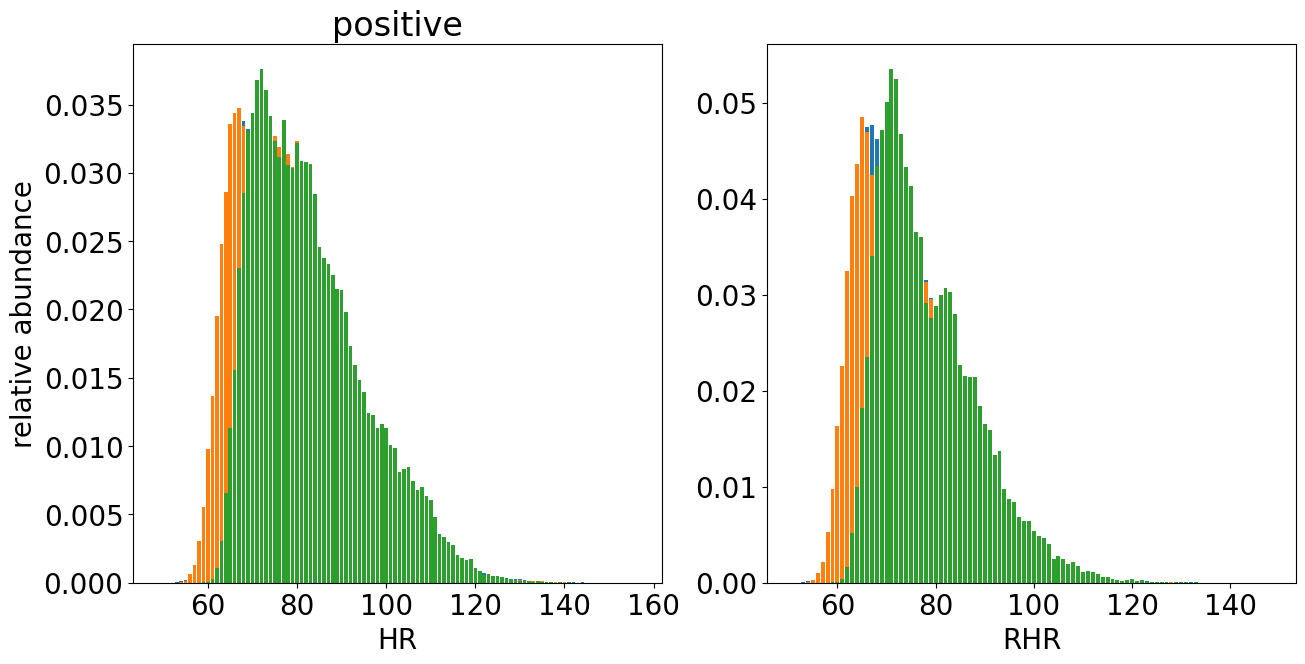

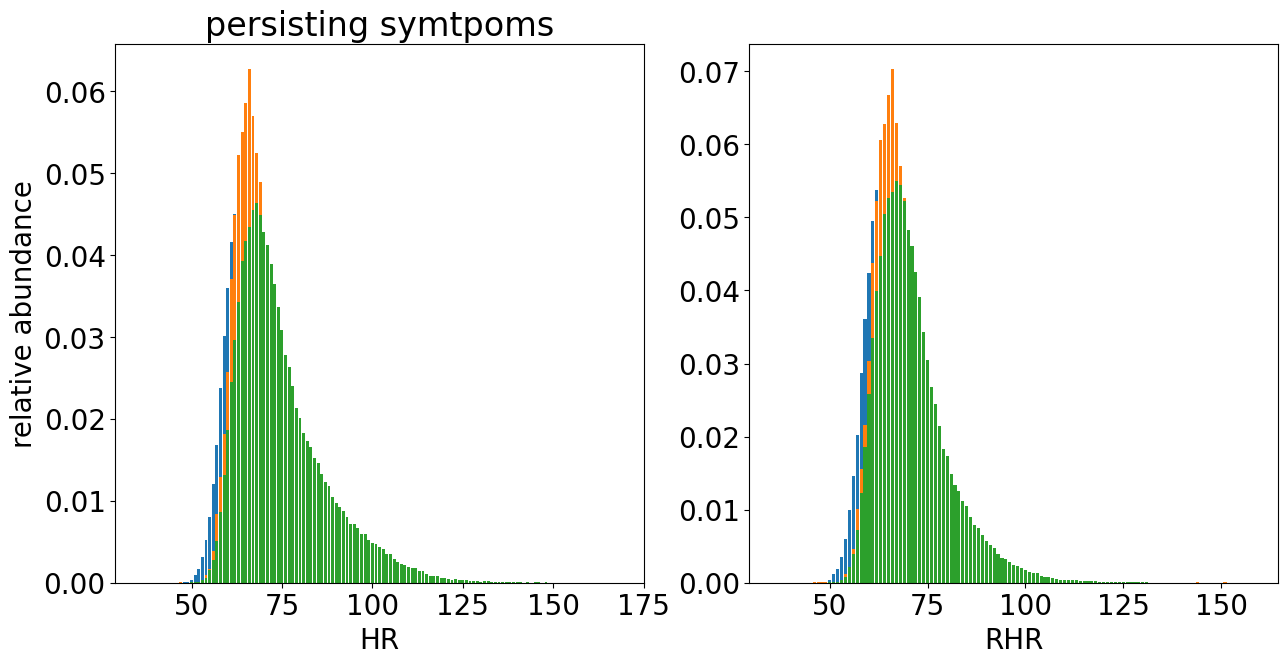

In [39]:
groups = ['negative', 'positive', 'persisting symtpoms']
i = 0
for ex in [neg, pos, lc]:
    fig, ax = plt.subplots(1,2,figsize=(15,7))
    for ph in [0,1,2]:
        hr = ex[(ex['type'] == 3000) & (ex['phase'] == ph) ][['longValue', 'tdelta_min']]    
        rhr = ex[(ex['type'] == 3001) & (ex['phase'] == ph) ][['longValue', 'tdelta_min']]    
        ax[0].bar(hr.groupby('longValue').sum().index, hr.groupby('longValue').sum()['tdelta_min']/hr.groupby('longValue').sum()['tdelta_min'].sum())
        ax[1].bar(rhr.groupby('longValue').sum().index,rhr.groupby('longValue').sum()['tdelta_min']/rhr.groupby('longValue').sum()['tdelta_min'].sum())
        
        ax[0].set_xlabel('HR')
        ax[1].set_xlabel('RHR')
        ax[0].set_ylabel('relative abundance')
        ax[0].set_title(groups[i])
    if i == 0:
        plt.legend(['pre (< 0 weeks)','acute (0-3 weeks)','post ( > 3 weeks)']);
    i +=1

In [59]:
steps = ex[(ex['type'] == 1000) & (ex['phase'] == ph) ][['doubleValue', 'tdelta_sec','entries']]   

In [61]:
steps['sps'] = steps['doubleValue']/steps['tdelta_sec']

In [66]:
steps.groupby('sps').sum()

,doubleValue,tdelta_sec,entries
sps,,,
0.020257,52.0,2567.0,1
0.033333,4.0,120.0,2
0.075000,9.0,120.0,1
0.083333,20.0,240.0,3
0.100000,36.0,360.0,6
...,...,...,...
10.000000,200.0,20.0,19
10.333333,31.0,3.0,1
11.000000,451.0,41.0,40


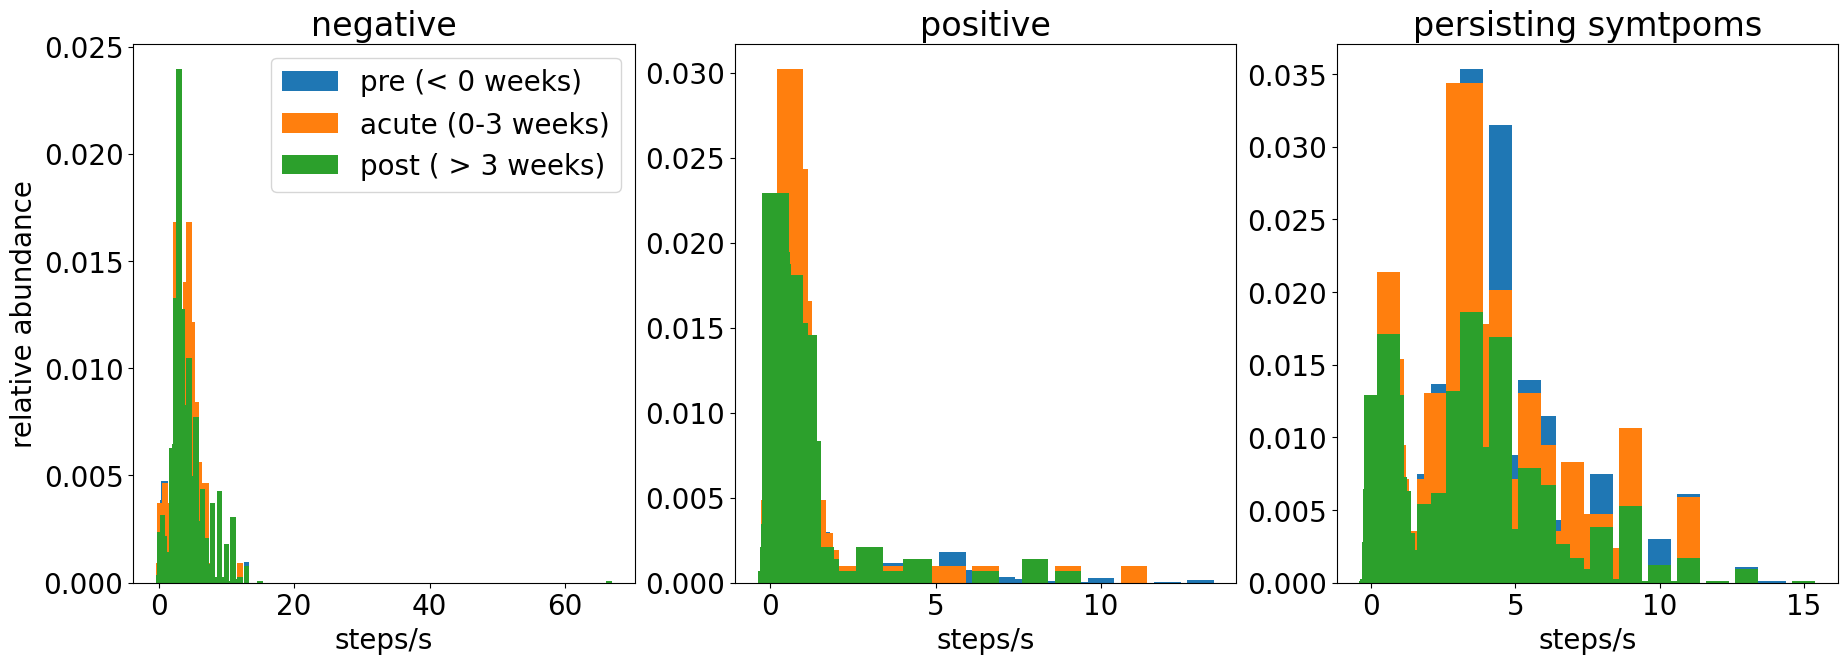

In [75]:
groups = ['negative', 'positive', 'persisting symtpoms']
i = 0
fig, ax = plt.subplots(1,3,figsize=(22,7))
for ex in [neg, pos, lc]:
    
    for ph in [0,1,2]:
        steps = ex[(ex['type'] == 1000) & (ex['phase'] == ph) ][['doubleValue', 'tdelta_sec','entries']]   
        steps['sps'] = steps['doubleValue']/steps['tdelta_sec']
        
        
        ax[i].bar(steps.groupby('sps').sum().index,steps.groupby('sps').sum()['entries']/steps.groupby('sps').sum()['entries'].sum())
        
        ax[i].set_xlabel('steps/s')
        
        ax[i].set_title(groups[i])
    if i == 0:
        ax[i].set_ylabel('relative abundance')
        ax[i].legend(['pre (< 0 weeks)','acute (0-3 weeks)','post ( > 3 weeks)']);
    i +=1

In [76]:
ex

,user_id,type,valueType,doubleValue,longValue,booleanValue,timezoneOffset,startTimestamp,endTimestamp,createdAt,source,dt,date,code,entries,tdelta,tdelta_min,tdelta_sec,week_totest,phase
0,357322,3001,1,NaN,58.0,NaN,0,2022-02-15 09:33:00,2022-02-15 09:34:00,1644974675348,3,2022-04-17,2022-02-15,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0
1,357322,3001,1,NaN,61.0,NaN,0,2022-02-15 09:34:00,2022-02-15 09:35:00,1644974675348,3,2022-04-17,2022-02-15,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0
2,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:35:00,2022-02-15 09:36:00,1644974675348,3,2022-04-17,2022-02-15,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0
3,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:36:00,2022-02-15 09:37:00,1644974675348,3,2022-04-17,2022-02-15,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0
4,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:37:00,2022-02-15 09:38:00,1644974675348,3,2022-04-17,2022-02-15,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459957,357322,1200,1,NaN,103.0,0.0,120,2020-10-02 05:22:00,2020-10-02 05:39:00,1601657128753,3,2022-04-17,2020-10-02,ActivityType,1,0 days 00:17:00,17.0,1020.0,-80,0
1459958,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 05:39:00,2020-10-02 06:21:00,1601657128771,3,2022-04-17,2020-10-02,ActivityType,1,0 days 00:42:00,42.0,2520.0,-80,0
1459959,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 05:40:00,2020-10-02 06:19:00,1601645338812,3,2022-04-17,2020-10-02,ActivityType,1,0 days 00:39:00,39.0,2340.0,-80,0
1459960,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 06:22:00,2020-10-02 06:25:00,1601657128773,3,2022-04-17,2020-10-02,ActivityType,1,0 days 00:03:00,3.0,180.0,-80,0


In [78]:
bins = list(range(0,25))

In [79]:
bins

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [82]:
ex['Time Bin 1'] = pd.cut(ex.startTimestamp.dt.hour, bins, right=False)
ex['Time Bin 2'] = pd.cut(ex.endTimestamp.dt.hour, bins, right=False)

In [83]:
ex

,user_id,type,valueType,doubleValue,longValue,booleanValue,timezoneOffset,startTimestamp,endTimestamp,createdAt,...,code,entries,tdelta,tdelta_min,tdelta_sec,week_totest,phase,Time Bin,Time Bin 1,Time Bin 2
0,357322,3001,1,NaN,58.0,NaN,0,2022-02-15 09:33:00,2022-02-15 09:34:00,1644974675348,...,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0,"[9, 10)","[9, 10)","[9, 10)"
1,357322,3001,1,NaN,61.0,NaN,0,2022-02-15 09:34:00,2022-02-15 09:35:00,1644974675348,...,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0,"[9, 10)","[9, 10)","[9, 10)"
2,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:35:00,2022-02-15 09:36:00,1644974675348,...,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0,"[9, 10)","[9, 10)","[9, 10)"
3,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:36:00,2022-02-15 09:37:00,1644974675348,...,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0,"[9, 10)","[9, 10)","[9, 10)"
4,357322,3001,1,NaN,57.0,NaN,0,2022-02-15 09:37:00,2022-02-15 09:38:00,1644974675348,...,HeartRateResting,1,0 days 00:01:00,1.0,60.0,-8,0,"[9, 10)","[9, 10)","[9, 10)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459957,357322,1200,1,NaN,103.0,0.0,120,2020-10-02 05:22:00,2020-10-02 05:39:00,1601657128753,...,ActivityType,1,0 days 00:17:00,17.0,1020.0,-80,0,"[5, 6)","[5, 6)","[5, 6)"
1459958,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 05:39:00,2020-10-02 06:21:00,1601657128771,...,ActivityType,1,0 days 00:42:00,42.0,2520.0,-80,0,"[5, 6)","[5, 6)","[6, 7)"
1459959,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 05:40:00,2020-10-02 06:19:00,1601645338812,...,ActivityType,1,0 days 00:39:00,39.0,2340.0,-80,0,"[5, 6)","[5, 6)","[6, 7)"
1459960,357322,1200,1,NaN,102.0,0.0,120,2020-10-02 06:22:00,2020-10-02 06:25:00,1601657128773,...,ActivityType,1,0 days 00:03:00,3.0,180.0,-80,0,"[6, 7)","[6, 7)","[6, 7)"


In [ ]:
#lc.groupby(['type','user_id']).sum()